# IBM Data Science Capstone Project

1. [Introduction](#intro)
2. [Data](#data)
3. [Methodology](#metho)
4. [Results](#results)
5. [Conclusion](#con)

---
# Introduction
---
#### The Business Problem

For this project we will try to find the best location for a new __karaoke box__ within the ___Special Wards of Tokyo, Japan (東京都区部)___.

There are 23 special wards in Tokyo Metropolis. The combined area of all special wards was formerly known as Tokyo City; however, in a legal sense the "City of Tokyo" does not exist. Presently, the combined area is still referred to as the city of Tokyo and we will utilize the special wards as a method to define the city of Tokyo. Also, since Chiyoda 千代田区 was the heart of former Tokyo City and is home to many major Japanese businesses and the national government, we will use Chiyoda as our _city center_.

Since there are many karaoke boxes in Tokyo, we will try to find __locations which are not already saturated with karaoke boxes__, with close attention to __areas with high population and few to no karaoke boxes nearby__.

We will try to find the most promising areas based on the above criteria.



# Data
---
Factors which will influence our decision: 
- number of karaoke boxes in the ward
- ward population
- activities / sights in the ward

We will utilize the following data sources to generate and/or extract more information:
- Data defining our wards will be scrapped from  __[Wikipedia](https://en.wikipedia.org/wiki/Special_wards_of_Tokyo)__
- for mapping the special wards, we will utlize geoJSON coordinates provided from user __[niiyz github](https://github.com/niiyz/JapanCityGeoJson/blob/master/geojson/13/tokyo23.json)__.
- to generate the location (latitude and longitude) of each special ward we will use __geopy.geocoders.Nominatim__
- to find the number of karaoke boxes and their locations in every special ward we will use __Foursquare API__

#### Project Imports

In [1]:
#imports
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import json
from pandas.io.json import json_normalize #transform JSON into pandas df
from geopy.geocoders import Nominatim #convert address into lat and long

#for webscrapping
import requests
from bs4 import BeautifulSoup

#ploting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium #map rendering library

#k-means clustering state
from sklearn.cluster import KMeans

### Defining Tokyo by Special Wards
We will webscrape a table containing information about Tokyo Special Wards from Wikipedia. We will import this into a dataframe, clean up and wrangle the data, and use GeoPy's Nominatim to find the latitude and longitude of each ward

In [2]:
#webscrape for Special Wards data
html_data = requests.get("https://en.wikipedia.org/wiki/Special_wards_of_Tokyo").text

#parse html_data using beautiful_soup
soup= BeautifulSoup(html_data,'html5lib')

#create column headers
columns = ['No.', 'Flag', 'Name', 'Kanji', 'Population (2016)', 'Density (/km^2)','Area (km^2)', 'Major Districts']
#extract table
t = soup.find('table', {'class': 'wikitable sortable'}).find('tbody')

#get data from table and store it
table_data = []
for row in t.find_all('tr'):
    t_row={}
    for i, j in zip(row.find_all('td'), columns):
        t_row[j]=i.text.strip()
    table_data.append(t_row)
table_data = table_data [1:] #remove first entry, it is blank

#convert to df
tokyo_df = pd.DataFrame(table_data)
#save a copy
tokyo_og = tokyo_df

#preview
tokyo_df

No.       Flag        Name Kanji Population (2016) Density (/km^2)  \
0        01                Chiyoda  千代田区          0059,441          05,100   
1        02                   Chūō   中央区          0147,620          14,460   
2        03                 Minato    港区          0248,071          12,180   
3        04               Shinjuku   新宿区          0339,211          18,620   
4        05                 Bunkyō   文京区          0223,389          19,790   
5        06                  Taitō   台東区          0200,486          19,830   
6        07                 Sumida   墨田区          0260,358          18,910   
7        08                   Kōtō   江東区          0502,579          12,510   
8        09              Shinagawa   品川区          0392,492          17,180   
9        10                 Meguro   目黒区          0280,283          19,110   
10       11                 OtaŌta   大田区          0722,608          11,910   
11       12               Setagaya  世田谷区          0910,868          15,690   
12       13                Shibuya   渋谷区          0227,850          15,080   
13       14                 Nakano   中野区          0332,902          21,350   
14       15               Suginami   杉並区          0570,483          16,750   
15       16                Toshima   豊島区          0294,673          22,650   
16       17                   Kita    北区          0345,063          16,740   
17       18                Arakawa   荒川区          0213,648          21,030   
18       19               Itabashi   板橋区          0569,225          17,670   
19       20                 Nerima   練馬区          0726,748          15,120   
20       21                 Adachi   足立区          0674,067          12,660   
21       22             Katsushika   葛飾区          0447,140          12,850   
22       23                Edogawa  江戸川区          0685,899          13,750   
23  Overall  9,375,104      15,146   619                               NaN   

   Area (km^2)                                    Major Districts  
0       011.66  Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...  
1       010.21  Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...  
2       020.37  Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...  
3       018.22  Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...  
4       011.29                              Hongō, Yayoi, Hakusan  
5       010.11                                      Ueno, Asakusa  
6       013.77                      Kinshichō, Morishita, Ryōgoku  
7       040.16  Kiba, Ariake, Kameido, Tōyōchō, Monzennakachō,...  
8       022.84  Shinagawa, Gotanda, Ōsaki, Hatanodai, Ōimachi,...  
9       014.67     Meguro, Nakameguro, Jiyugaoka, Komaba, Aobadai  
10      060.66                Ōmori, Kamata, Haneda, Den-en-chōfu  
11      058.05        Shimokitazawa, Kinuta, Karasuyama, Tamagawa  
12      015.11        Shibuya, Ebisu, Harajuku, Daikanyama, Hiroo  
13      015.59                                             Nakano  
14      034.06                           Kōenji, Asagaya, Ogikubo  
15      013.01               Ikebukuro, Komagome, Senkawa, Sugamo  
16      020.61                               Akabane, Ōji, Tabata  
17      010.16             Arakawa, Machiya, Nippori, Minamisenju  
18      032.22                           Itabashi, Takashimadaira  
19      048.08                        Nerima, Ōizumi, Hikarigaoka  
20      053.25                      Ayase, Kitasenju, Takenotsuka  
21      034.80                 Tateishi, Aoto, Kameari, Shibamata  
22      049.90                                       Kasai, Koiwa  
23         NaN                                                NaN

#### Let's Clean
- drop unnecessary columns (No., Flag) and reorder for readablity
- Add latitude and longitude for each ward
- Check for duplicates

In [3]:
#drop unnecessary columns 
tokyo_df = tokyo_df.drop(['No.', 'Flag'], axis=1)
#drop final row
tokyo_df = tokyo_df.drop(index=23)

#remove the macron off the long vowels for the romanized names in "Name"
tokyo_df['Name'] = tokyo_df['Name'].replace({'Chūō':'Chuo', 'Bunkyō':'Bunkyo', 'Taitō':'Taito', 'Kōtō':'Koto', 'OtaŌta':'Ota'})

#add columns for latitude and longitude
tokyo_df['Latitude'] = np.nan
tokyo_df['Longitude'] = np.nan

#reorder
tokyo_df = tokyo_df[['Name', 'Kanji', 'Latitude', 'Longitude', 'Population (2016)', 'Density (/km^2)', 'Area (km^2)', 'Major Districts']]

#change Population, Density, and Area to floats
#we will use population and density as another factor to aid our analysis
tokyo_df['Population (2016)'] = tokyo_df['Population (2016)'].str.replace(',', '').astype(float)
tokyo_df['Density (/km^2)'] = tokyo_df['Density (/km^2)'].str.replace(',', '').astype(float)
tokyo_df['Area (km^2)'] = tokyo_df['Area (km^2)'].astype(float)

Now we will populate the `Latitude` and `Longitude` values for each special ward

In [4]:
#Lets use geolocator to find the coordinates
geolocator = Nominatim(user_agent='nihon')
lats = []
long = []

for ward in tokyo_df['Kanji']:
    location = geolocator.geocode(ward + ', 日本')
    if(location):
       # print('{0} - {1}, {2}'.format(ward, location.latitude, location.longitude))
        lats.append(location.latitude)
        long.append(location.longitude)
    else:
        print("unknown for: "+ ward )
        lats.append(np.nan)
        long.append(np.nan)

tokyo_df['Latitude'] = lats
tokyo_df['Longitude']= long

In [5]:
#lets check our df for NaN and preview
print(tokyo_df.isnull().any())
tokyo_df.head()

Name                 False
Kanji                False
Latitude             False
Longitude            False
Population (2016)    False
Density (/km^2)      False
Area (km^2)          False
Major Districts      False
dtype: bool


Name Kanji   Latitude   Longitude  Population (2016)  Density (/km^2)  \
0   Chiyoda  千代田区  35.693810  139.753216            59441.0           5100.0   
1      Chuo   中央区  35.666255  139.775565           147620.0          14460.0   
2    Minato    港区  35.643227  139.740055           248071.0          12180.0   
3  Shinjuku   新宿区  35.693763  139.703632           339211.0          18620.0   
4    Bunkyo   文京区  35.718810  139.744732           223389.0          19790.0   

   Area (km^2)                                    Major Districts  
0        11.66  Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...  
1        10.21  Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...  
2        20.37  Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...  
3        18.22  Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...  
4        11.29                              Hongō, Yayoi, Hakusan

#### Create a  GeoSpatial Visualization

In [6]:
#get lat/long for tokyo centered on chiyoda
address ='千代田区'
geolocator = Nominatim(user_agent='jp_explorer')
location = geolocator.geocode(address)
latitude= location.latitude
longitude= location.longitude
print('The coordinates of Chiyoda, Tokyo are {},{}.'.format(latitude,longitude))

#create map centered on chiyoda
jp_map = folium.Map(location=[latitude, longitude], zoom_start=11, tiles = 'Stamen Toner')

#import geoJSON for special ward outlines to add to map, this will help visualize the divisions
url = 'https://raw.githubusercontent.com/acrisler/JapanCityGeoJson/master/geojson/13/tokyo23.json'
geo_json = requests.get(url).text

#import the geoJSON data for each ward
outlines= folium.GeoJson(data = geo_json, 
                         style_function = lambda feature :{'fillColor': '#145D7D','color':'#145D7D','fillOpacity': '0.85'})
#add to map
outlines.add_to(jp_map)


# instantiate a feature group for the cities in the dataframe
wards = folium.map.FeatureGroup()

# loop through and add each to the incidents feature group
for lat, lng, label in zip(tokyo_df.Latitude, tokyo_df.Longitude, tokyo_df.Name):
    wards.add_child(
        folium.Marker([lat, lng],
                     popup=label,
                     icon= folium.DivIcon(html=f"""<div style="font-family: georgia; color:#7d145d ; font-size: large;">★</div>"""))
     )   
    
# add cities to map
jp_map.add_child(wards)

The coordinates of Chiyoda, Tokyo are 35.6938097,139.7532163.


## Foursquare API
Now that we have the coordinates for each ward, we can use the foursquare API to get info on __karaoke boxes__ in each special ward

Based on Foursquare Developers documentation for [category IDs](https://developer.foursquare.com/docs/build-with-foursquare/categories/) we know that the code for Karaoke Box is __5744ccdfe4b0c0459246b4bb__ and this code is supported in JP


In [26]:
#define Foursquare credentials and version
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
# radius = 5000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


lets get venues!!

In [8]:
karaoke_id = '5744ccdfe4b0c0459246b4bb' #category for all Karaoke boxes

In [9]:
#function to get karaoke box locations in all special wards
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            karaoke_id,
            radius, 
            LIMIT)
#         print(url) #display url for further investigation
        
        #GET request
        results = requests.get(url).json()['response']
        
        for venue in results['venues']:
            venues_list.append([
                name,
                lat,
                lng,
                venue['name'],
                venue['location']['lat'],
                venue['location']['lng']])
        
    nearby_venues = pd.DataFrame([venue for venue in venues_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [10]:
#run function for all wards
tokyo_venues = getNearbyVenues(names=tokyo_df['Kanji'],
                                   latitudes=tokyo_df['Latitude'],
                                   longitudes=tokyo_df['Longitude']
                                  )
#check out df
print(tokyo_venues.shape)
tokyo_venues.head()

(734, 6)


Ward  Ward Latitude  Ward Longitude                      Venue  \
0  千代田区       35.69381      139.753216            カラオケまねきねこ 神田小川町   
1  千代田区       35.69381      139.753216               カラオケ館 神田小川町店   
2  千代田区       35.69381      139.753216          カラオケの鉄人 秋葉原昭和通り口店   
3  千代田区       35.69381      139.753216  PASELA (カラオケパセラ 秋葉原昭和通り館)   
4  千代田区       35.69381      139.753216                カラオケ館 上野駅前店   

   Venue Latitude  Venue Longitude  
0       35.695247       139.761460  
1       35.695934       139.761630  
2       35.698384       139.775188  
3       35.697605       139.775999  
4       35.710701       139.775469

In [11]:
#check for venue duplicates based on venue lat/long
tokyo_venues.duplicated().any()

False

Some quick stats about the veunues foursquare returned

In [12]:
#some stats
print('Total number of karaoke boxes: ', len(tokyo_venues))
print('Percentage of unique venues: {:.2f}%'.format( len(tokyo_venues['Venue'].unique()) / len(tokyo_venues['Venue']) *100 ))
#number of venues per ward?? should be 50 each

Total number of karaoke boxes:  734
Percentage of unique venues: 69.48%



# Methodology
---
## Visualize the Venues (Karaoke Boxes)

First, lets assign a random color for each ward to help visual our locations.

In [13]:
import random
number_of_colors = 23
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
# print(len(color))

# Run thru unique Wards and assign color
color_dict = {}
index = 0
for ward in tokyo_venues['Ward'].unique():
#     print(ward)
    color_dict[ward] = color[index]
    index += 1

tokyo_venues.head()
# Run thru tokyo_venue row by row and assign color from color_dict
for i in tokyo_venues.index:
    tokyo_venues.at[i, 'colors'] = color_dict[tokyo_venues.at[i, 'Ward']]

Now, we will add each karaoke box returned from foursquare to our map and display it

In [14]:
# instantiate a feature group for the karaoke boxes in the dataframe
boxes = folium.map.FeatureGroup()

# loop through and add each to the incidents feature group
for lat, lng, clr in zip(tokyo_venues['Venue Latitude'], tokyo_venues['Venue Longitude'], tokyo_venues['colors']):
    boxes.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=2, # define how big you want the circle markers to be
            fill=False,
            color = clr
        )
    )   
    
# add cities to map
jp_map.add_child(boxes)
jp_map

Thats a bit cluttered, but it is nice to get a visual of where karaoke boxes are frequently located. These are colored by ward. Since the foursquare results are rendered from the general ward coordinates (star on the map), within a 2500 meter radius around that point, some venue locations cross the special ward's boundaries. Nonetheless, they will be considered for the resepective ward. 

#### Let's explore the foursquare results further

In [15]:
#lets group up the venues by `ward`
vennums = tokyo_venues['Ward'].value_counts()
print ("number of venues found in each ward:")
print(vennums)

number of venues found in each ward:
新宿区     50
台東区     50
文京区     50
渋谷区     50
千代田区    50
中央区     49
豊島区     49
港区      46
墨田区     42
北区      41
荒川区     32
中野区     31
目黒区     28
世田谷区    28
大田区     28
杉並区     23
品川区     21
江戸川区    17
葛飾区     13
練馬区     12
板橋区     12
足立区      7
江東区      5
Name: Ward, dtype: int64


We will save these values into a temporary dataframe and then merge them with our original dataframe `tokyo_df`

In [16]:
#rename the df vennums
vennums.name='Number of Venues'

#lets merge vennums with our original df tokyo_df using `Kanji` as the keys
tokyo_df = tokyo_df.join(vennums, on='Kanji')

#preview merge
tokyo_df.head()

Name Kanji   Latitude   Longitude  Population (2016)  Density (/km^2)  \
0   Chiyoda  千代田区  35.693810  139.753216            59441.0           5100.0   
1      Chuo   中央区  35.666255  139.775565           147620.0          14460.0   
2    Minato    港区  35.643227  139.740055           248071.0          12180.0   
3  Shinjuku   新宿区  35.693763  139.703632           339211.0          18620.0   
4    Bunkyo   文京区  35.718810  139.744732           223389.0          19790.0   

   Area (km^2)                                    Major Districts  \
0        11.66  Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...   
1        10.21  Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...   
2        20.37  Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...   
3        18.22  Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...   
4        11.29                              Hongō, Yayoi, Hakusan   

   Number of Venues  
0                50  
1                49  
2                46  
3                50  
4                50

lets sort these values by number of venues (karaoke boxes) and population

<AxesSubplot:xlabel='Name'>

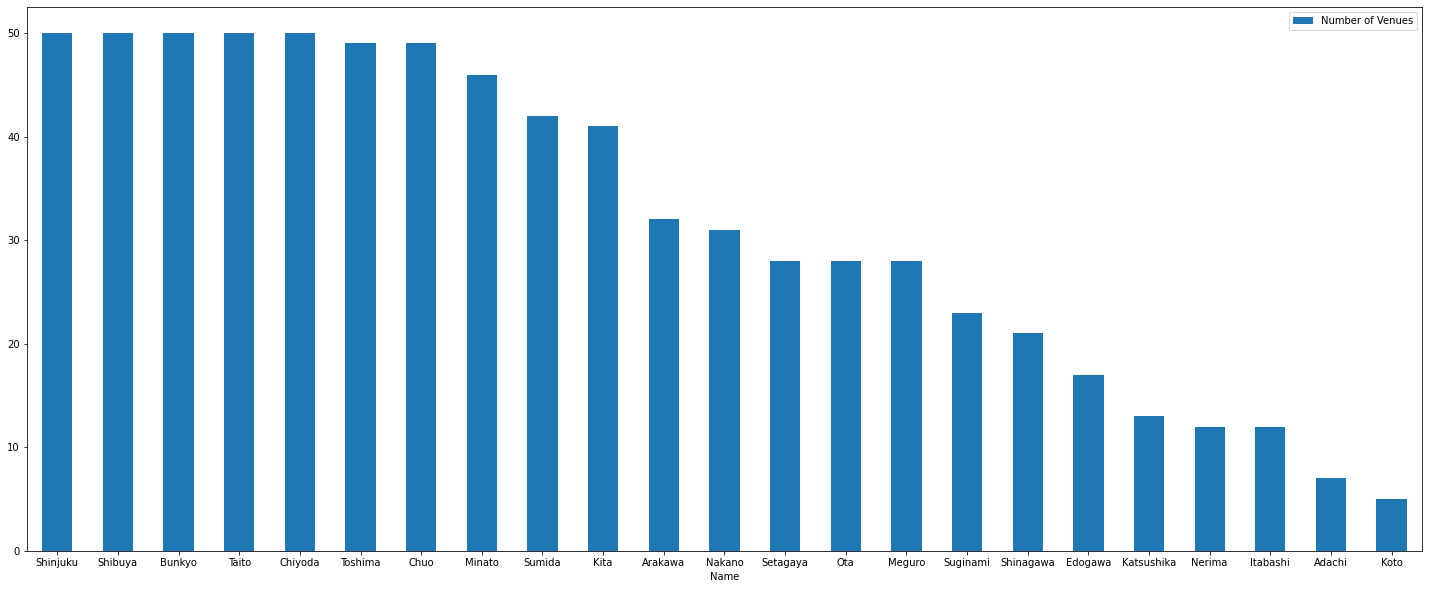

In [17]:
#save as new df
tokyo_boxes = tokyo_df.sort_values(['Number of Venues', 'Population (2016)'], ascending=False)

#and plot
tokyo_boxes.plot.bar(x='Name', y="Number of Venues", rot=0, figsize=(25,10))

We can see that Taito, Bunkyo, Shinjuku, Shibuya, Chiyoda already have **at least** 50 karaoke boxes (Foursquare has a limit of 50 searches, therefore we know there are at least 50 but there could be more). These wards, although extrememly popular, likely do not need more karaoke boxes. Toshima, Chuo, Sumida, and Kita wards also have a high number of karaoke boxes, but they may still be wards we are interested in opening our new karaoke box.

Let's take a closer look at the population in each special ward

In [18]:
for name, boxes, pop in zip(tokyo_boxes['Name'], tokyo_boxes['Number of Venues'], tokyo_boxes['Population (2016)']):
    print("The city of {} has {} karaoke boxes for a population of {}.".format(name, boxes, pop))

The city of Shinjuku has 50 karaoke boxes for a population of 339211.0.
The city of Shibuya has 50 karaoke boxes for a population of 227850.0.
The city of Bunkyo has 50 karaoke boxes for a population of 223389.0.
The city of Taito has 50 karaoke boxes for a population of 200486.0.
The city of Chiyoda has 50 karaoke boxes for a population of 59441.0.
The city of Toshima has 49 karaoke boxes for a population of 294673.0.
The city of Chuo has 49 karaoke boxes for a population of 147620.0.
The city of Minato has 46 karaoke boxes for a population of 248071.0.
The city of Sumida has 42 karaoke boxes for a population of 260358.0.
The city of Kita has 41 karaoke boxes for a population of 345063.0.
The city of Arakawa has 32 karaoke boxes for a population of 213648.0.
The city of Nakano has 31 karaoke boxes for a population of 332902.0.
The city of Setagaya has 28 karaoke boxes for a population of 910868.0.
The city of Ota has 28 karaoke boxes for a population of 722608.0.
The city of Meguro ha

Normalize the data so we can render a visual comparision of the amount of karaoke boxes with respect to the ward's population

<AxesSubplot:xlabel='Name'>

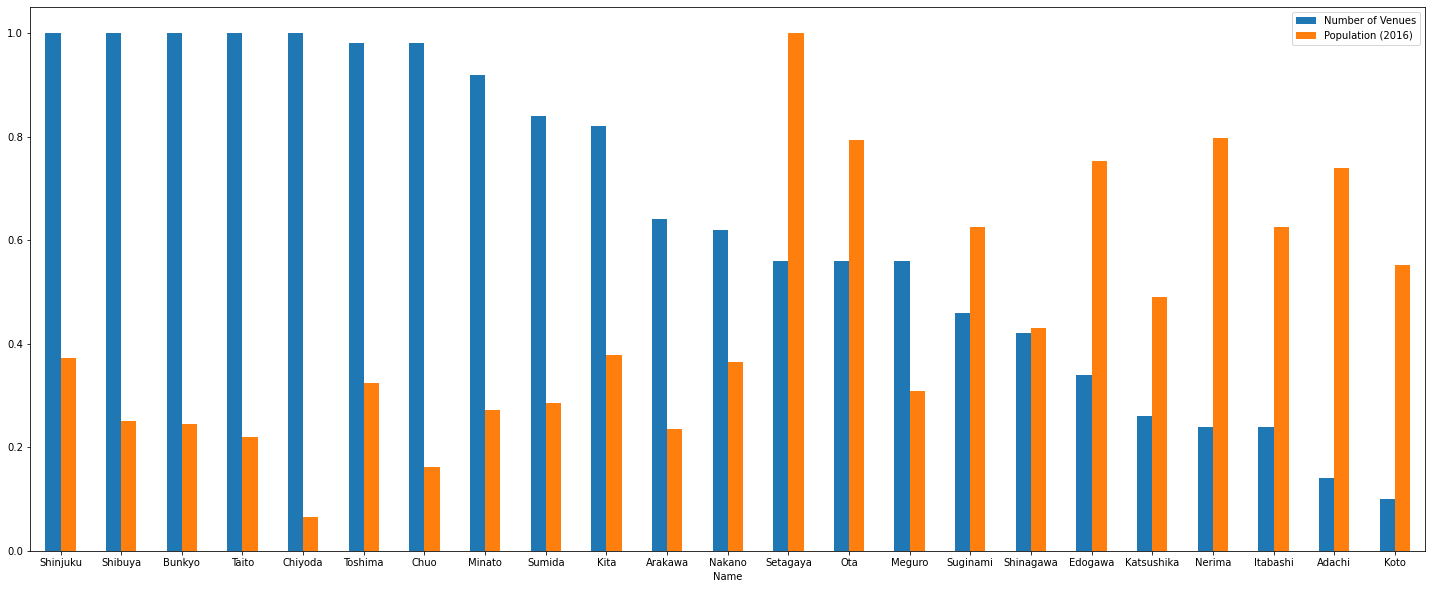

In [19]:
#lets normalize the data for a visual comparision 
tokyo_max_scaled = tokyo_boxes[['Name', 'Population (2016)','Number of Venues']].copy()

#apply normalization techniques
tokyo_max_scaled['Number of Venues'] = tokyo_max_scaled['Number of Venues'] / tokyo_max_scaled['Number of Venues'].abs().max()
tokyo_max_scaled['Population (2016)'] = tokyo_max_scaled['Population (2016)'] / tokyo_max_scaled['Population (2016)'].abs().max()

# tokyo_max_scaled.head()

tokyo_max_scaled.plot.bar(x='Name', y=['Number of Venues', 'Population (2016)'], rot=0, figsize =(25,10))

#### This is interesting! Let's Explore More~

__What are some possible reasons why some wards have a large number of karaoke boxes in comparision to their population (when normalized)?__

Special Wards such as Shinjuku, Shibuya, Bunkyo, Taito, Chiyoda, Toshima, and Chuo are home to very important and popular districts in Tokyo. These districts are known for government, business, shopping, food, and entertainment. Chiyoda, Chuo, and Minato -- the business core of Tokyo -- have a daytime population that exceeds 7x the nighttime population __[[1]](https://en.wikipedia.org/wiki/Tokyo#cite_note-51)__ . This could be a large contributor to the popularity of karaoke boxes despite the ward's relatively low population.


We will look more closely at wards with high population and low karaoke boxes, narrowing down our search to the top 5 locations where the difference between population and karaoke boxes is large

In [20]:
#lets get only the top 5 wards where population is larger than the amount of karaoke boxes 
tokyo_narrowed = tokyo_max_scaled[tokyo_max_scaled['Population (2016)'] > tokyo_max_scaled['Number of Venues']]

#create a column that expresses the difference between population and number of venues numerically
d=[]
for pop, ven in zip(tokyo_narrowed['Population (2016)'], tokyo_narrowed['Number of Venues']):
    d.append(pop - ven)
    
#add to tokyo_narrowed and sort by difference and focus on exploring those areas
tokyo_narrowed['sort']= d
tokyo_narrowed = tokyo_narrowed.sort_values(['sort','Population (2016)'], ascending=False)

#save only the top five values
tokyo_narrowed= tokyo_narrowed.head()

<ipython-input-20-6c138a67aa3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokyo_narrowed['sort']= d


<AxesSubplot:xlabel='Name'>

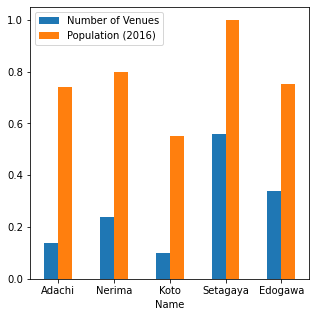

In [21]:
#plot the wards with population greater than # of karaoke boxes, sorted by the largest difference
tokyo_narrowed.plot.bar(x='Name', y=['Number of Venues', 'Population (2016)'], rot=0, figsize =(5,5))

Let's look a bit more into these wards and see if we can further narrow down our candidate wards


In [22]:
#first lets create new df which our current candidates (seen above)

tdf = tokyo_df 
tdf.set_index(['Name'], inplace=True)
tdf= tdf.loc[['Adachi','Nerima','Koto','Setagaya','Edogawa']]
tdf=tdf.reset_index()

In [23]:
#create narrowed down df for venues
#get venues for wards in tdf
tdf_venues = tokyo_venues
tdf_venues.set_index(['Ward'], inplace =True)

tdf_venues=tdf_venues.loc[['足立区','練馬区', '江東区', '世田谷区', '江戸川区']]
tdf_venues=tdf_venues.reset_index()
# tdf_venues['Ward'].unique()

#### Create a visual of our top 5 choices

In [24]:
#render new map
#create map centered on chiyoda
jm = folium.Map(location=[latitude, longitude], zoom_start=11, tiles = 'Stamen Toner')

#geoJSON data for each ward
lines= folium.GeoJson(data = geo_json, 
                         style_function = lambda feature :{'fillColor': '#145D7D','color':'#002A4A','fillOpacity': '0.85'})
#add to map
lines.add_to(jm)

# instantiate a feature group for the cities in the dataframe
narrowed_wards = folium.map.FeatureGroup()

# loop through and add each to the incidents feature group
for lat, lng, label in zip(tdf.Latitude, tdf.Longitude, tdf.Name):
    narrowed_wards.add_child(
        folium.Marker([lat, lng],
                     popup=label,
                     icon= folium.DivIcon(html=f"""<div style="font-family: georgia; color:#7d145d ; font-size: large;">★</div>"""))
     )   
    
# add cities to map
jm.add_child(narrowed_wards)

#add venues
kb = folium.map.FeatureGroup()

# loop through and add each to the incidents feature group
for lat, lng, clr in zip(tdf_venues['Venue Latitude'], tdf_venues['Venue Longitude'], tdf_venues['colors']):
    kb.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=4, # define how big you want the circle markers to be
            fill=False,
            color = clr
        )
    )   
    
# add cities to map
jm.add_child(kb)
jm


As expected, the wards we are looking at are the wards a bit further away from the heart of Tokyo. This is OK, we can narrow it down to a single ward

Some factors that may be considered for finding the best location for a new karaoke box could include:
- ward population 
- which districts are popular and why they're popular
- district daytime and nightime activies
- proximity to train station
- distance to nearest karaoke box

Diving deeply into some of these factors is out of the scope of this project, since we are trying to determine which ward would be the best for opening a new box and not necessarily the exact location for a new box. However, some of the factors listed above are worthwhile to explore a bit to narrow down our search.

In [25]:
#lets checkout what districts are in each ward
for nm, ds, pop in zip(tdf['Name'], tdf['Major Districts'], tdf['Population (2016)']):
    print("Name: ", nm)
    print("Districts:", ds)
    print("Total Population: ", pop)
    print("------------------")

Name:  Adachi
Districts: Ayase, Kitasenju, Takenotsuka
Total Population:  674067.0
------------------
Name:  Nerima
Districts: Nerima, Ōizumi, Hikarigaoka
Total Population:  726748.0
------------------
Name:  Koto
Districts: Kiba, Ariake, Kameido, Tōyōchō, Monzennakachō, Fukagawa, Kiyosumi, Shirakawa, Etchūjima, Sunamachi, Aomi
Total Population:  502579.0
------------------
Name:  Setagaya
Districts: Shimokitazawa, Kinuta, Karasuyama, Tamagawa
Total Population:  910868.0
------------------
Name:  Edogawa
Districts: Kasai, Koiwa
Total Population:  685899.0
------------------


# Results and Discussion
---

To get a better understanding of what there is to do in each of these wards, we will briefly mention some major sights or things to do in each ward. While there are many things that could help us narrow down the search, we will choose a location based on the **type of activities avaliable**, as well as the **amount of venues** in respect to **population**.

Our top 5 locations are : Adachi 足立区, Nerima 練馬区, Koto 江東区, Setagaya 世田谷区, and Edogawa 江戸川区

#### Local Sights
Sights Adachi __[[2]](https://en.wikipedia.org/wiki/Adachi,_Tokyo)__ :
- Nishiarai Daishi - One of the Three Great Temples in the Kanto region
- Parks - Toneri, Higashi Ayase, Toshi Nogyo Koen (Urban Agricultural Park), Adachi Park of Living Things
- Halls and Cultural Facilites - Tokyo Budokan (martial arts hall), Galaxy+City, Theartre 1010, Adachi Historical Museum

Sights in Nerima __[[3]](https://en.wikipedia.org/wiki/Nerima)__ :
- Toshimaen Amusement Park
- Museums - Ward art museum and Iwasaki Chihiro illustrated book museum
- Parks - Hikarigaoka, Shakujii, Oizumi-Chuo, Musashiseki, Johoku-Chou, Takamatsu

Sights in Koto __[[4]](https://en.wikipedia.org/wiki/Kōtō)__ :
- AgeHa Nightclub
- Shrines - Kameido Tenjin, Tomioka Hachiman
- Museums and Gardens - Fukagawa Edo Museum, Kiyosumi Garden, Museum of Contemporary Art Tokyo, Tokyo Big Sight, Yumenoshima Tropical Greenhouse Dome
- Sports - Ariake Coliseum, Ariake Tennis Forest Park, Suzaki Baseball Field
- Fukagawa : an historical area of Tokyo City (下町）

Sights in Setagaya __[[5]](https://en.wikipedia.org/wiki/Setagaya)__ :
- Gotoku-ji - a temple with Ii Naosuke, Zenyomitsu-ji
- Komazawa Olympic Park, Kinuta Park, Stagaya Castle ruins, Tamagawadai Park
- Hasegawa Machiko Art Museum, NHK Science and Technology Research Labs, Seikado Bunko Art Museum, Setagaya Art Museum, Setagaya Literary Museum
- Setagaya Business Square
- Shimokita : A popular commercial and entertainment district, full of fashion retailers, cafes, theaters, bars, and live music venues ***

Sights in Edogawa __[[6]]()__ :
- Boat Race Course
- Parks - Edogawa Stadium, Kasai Seaside park


---

# Conclusion

**Setagaya** has the *highest population* with a lot of *general activities* in the ward. **Nerima** and **Adachi** follow in population. The ward of **Koto** also has a high population number with a good amount of activities avaliable. All of our top choices are *good* choices for a new karaoke box.

Based on the amount of karaoke boxes returned by foursquare in comparison to the ward population, and a brief overview of activities avaliable in the area. I would suggest to consider ***Setagaya as the ward to open a new karaoke box in***. The *population is high, along major train routes in and out of downtown Tokyo, the district Shimokitazawa is very popular and contains many retailers, cafes, bars and live music venues-- which can draw people into the business*. We can continue to narrow down our results but believe this is a good point to bring our findings to stakeholders to gauge how much they agree with our conclusion and location selection. From here we can also decide on the direction and particular audience we intend to target. 